- 지난번에 코딩할때, 제대로 모듈화도 하지 않고, 너무 막 코딩하여 이 노트북에서는 좀 정리를 해놓으려고 합니다. 
    - 아직 추가로 하지 못한 부분이 많아서, 해야할게 많거든요. 아무튼. 
    

drop 2830 row
keyword filtering 완료


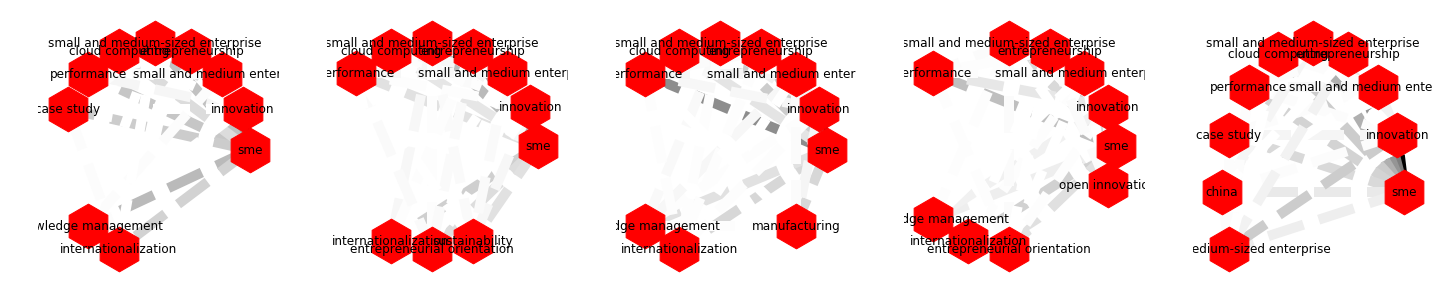

In [72]:
"""
required library 
"""
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from inflection import singularize 
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler

from pptx import Presentation
from pptx.util import Inches

import warnings
warnings.filterwarnings('ignore')

"""
desc: centrality를 계산하는 함수들입니다. 
input: graph(undirected)
output: dictionary
"""
def return_weighted_degree_centrality(input_g, normalized=True):
    w_d_centrality = {n:0.0 for n in input_g.nodes()}
    for u, v, d in input_g.edges(data=True):
        w_d_centrality[u]+=d['weight']
        w_d_centrality[v]+=d['weight']
    if normalized==True:
        weighted_sum = sum(w_d_centrality.values())
        return {k:v/weighted_sum for k, v in w_d_centrality.items()}
    else:
        return w_d_centrality
def return_closeness_centrality(input_g):
    new_g_with_distance = input_g.copy()
    for u,v,d in new_g_with_distance.edges(data=True):
        if 'distance' not in d:
            d['distance'] = 1.0/d['weight']
    return nx.closeness_centrality(new_g_with_distance, distance='distance')
def return_betweenness_centrality(input_g):
    return nx.betweenness_centrality(input_g, weight='weight')
def return_pagerank(input_g):
    return nx.pagerank(input_g, weight='weight')

"""
desc: pd.DataFrame의 특정 칼럼(each element is list)의 모든 리스트를 합친 다음 Counter => pd.DataFrame
input: pd.DataFrame
output: pd.DataFrame
"""
def total_count(input_df, column_name='Author Keywords'):
    # 'Author Keywords' or 'Noun Phrases'
    r = itertools.chain.from_iterable(input_df[column_name])
    r = Counter(r).most_common()
    return pd.DataFrame(r, columns=[column_name, 'count'])
"""
desc: 전체적으로 listfmf filtering하여 리턴한다. 
input: pd.DataFrame(each element is list of kwd)
output: pd.DataFrame
"""
def filtering_auth_kwds(input_df,column_name='Author Keywords', above_n=3):
    """
    개별 node가 전체에서 1번 밖에 등장하지 않는 경우도 많은데, 이를 모두 고려해서 분석을 하면, 효율적이지 못한 계산이 된다. 
    따라서, 빈도가 일정 이상을 넘는 경우에 대해서만 고려하여 new_df를 수정하는 것이 필요하다. 
    """
    # singularize 
    input_df[column_name] = input_df[column_name].apply(lambda ks: [singularize(k).strip().lower() for k in ks])
    # drop low count kwd 
    filtered_kwds = total_count(input_df, column_name=column_name)
    filtered_kwds = set(filtered_kwds[filtered_kwds['count']>=above_n][column_name])
    input_df[column_name] = input_df[column_name].apply(lambda ks: list(filter(lambda k: True if k in filtered_kwds else False, ks)))
    # edge를 만들때 중복을 방지하기 위해서 sorting해둔다. 
    input_df[column_name] = input_df[column_name].apply(lambda l: sorted(list(set(l))))
    """
    word embeddingd 등 다른 데이터 전처리가 필요하다면 여기서 처리하는 것이 좋음. 
    """
    return input_df# 사실 굳이 return을 쓸 필요가 없음. 이미 내부에서 다 바꿔줌. 
"""
desc: 연도별로 상위 빈도 키워드를 50개씩 칼럼별로 보여줌
input: pd.DataFrame
output: pd.DataFrame(column 이름은 각 연도)
"""
def yearly_count_rank(input_df, column_name='Author Keywords', until_rank_n=50):
    r_dict = {}
    for year, year_df in input_df.groupby('Year'):
        r_dict[year] = list(total_count(year_df, column_name=column_name)[column_name])[:until_rank_n]
        if len(r_dict[year])<until_rank_n:
            for i in range(0, until_rank_n - len(r_dict[year])):
                r_dict[year].append("")
    return pd.DataFrame(r_dict)

def make_centrality_df(inputG, cent_func):
    deg_cent = cent_func(inputG)
    deg_cent = sorted([(k, v) for k, v in deg_cent.items()], key=lambda x: x[1], reverse=True)
    return pd.DataFrame(deg_cent, columns=['node', 'centrality'])
    
def yearly_centrality_rank(input_df, cent_func, column_name='Author Keywords', until_rank_n=50):
    r_dict = {}
    for year, year_df in input_df.groupby('Year'):
        yearG = make_graph(year_df)
        """
        node_weight_lst = [n[1]['weight'] for n in yearG.nodes(data=True)]
        if len(node_weight_lst)>100:
            node_weight_threshold = node_weight_lst[100]
        else:
            node_weight_threshold = node_weight_lst[-1]
        yearG = drop_low_weighted_node(yearG, node_weight_threshold)
        """
        r_dict[year] = list(make_centrality_df(yearG, cent_func)['node'])[:50]
        if len(r_dict[year])<until_rank_n:
            r_dict[year]+=["" for i in range(0, until_rank_n - len(r_dict[year]))]
    return pd.DataFrame(r_dict)
"""
desc: df로부터 그래프를 생성하는 함수
input: pd.DataFrame
output: nx.Graph
"""
def make_graph(input_df, column_name='Author Keywords'):
    # make edges: edge가 중복으로 생기지 않게 하려면, 
    def make_edges_from_lst(lst):
        if len(lst)>1:
            return [(lst[i], lst[j]) for i in range(0, len(lst)-1) for j in range(i+1, len(lst))]
        else:
            return []
    nodes = total_count(input_df)
    new_nodes = []
    for i in range(0, len(nodes)):
        name = nodes[column_name].iloc()[i]
        w = nodes['count'].iloc()[i]
        new_nodes.append( (name, {'weight':w}) )
    nodes = new_nodes
    edges = itertools.chain.from_iterable(input_df[column_name].apply(make_edges_from_lst))
    edges = ((uv[0], uv[1], w) for uv, w in Counter(edges).most_common())
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(edges)
    # graph에 대한 데이터 필터링이 필요할 수 있는데. 여기서. 
    return G
"""
desc: graph에서 일정 수 이하의 weight를 가진 edgef를 삭제한 그래프를 리턴한다. 
만약 edge가 없어져서, node가 isolatede될 경우 해당 node도 함께 없애준다. 
input: graph
output: graph 
"""
def drop_low_weighted_edge(inputG, above_weight=3):
    rG = nx.Graph()
    rG.add_nodes_from(inputG.nodes(data=True))
    edges = filter(lambda e: True if e[2]['weight']>=above_weight else False, inputG.edges(data=True))
    rG.add_edges_from(edges)
    for n in inputG.nodes(): # neighbor가 없는 isolated node를 모두 지운다. 
        if len(list(nx.all_neighbors(rG, n)))==0:
            rG.remove_node(n)
    return rG
"""
desc: graph에서 일정 수 이하의 weight를 가진 node를 삭제한 그래프를 리턴한다. 
input: graph
output: graph 
"""
def drop_low_weighted_node(inputG, above_weight=3):
    rG = nx.Graph()
    rG.add_nodes_from(inputG.nodes(data=True))
    rG.add_edges_from(inputG.edges(data=True))
    for n in inputG.nodes(data=True):
        if n[1]['weight'] <= above_weight:
            rG.remove_node(n[0])
    rrG = rG.copy()
    for n in rG.nodes():# 만약 node가 isolated 면 삭제한다. 
        if len(list(nx.all_neighbors(rG, n)))==0:
            rrG.remove_node(n)
    return rrG
"""
desc: 이 함수에서는 따로 node, edge를 filtering하지 않고 그래프를 그대로 그려줍니다. 
input: graph
output: none(plt.show() or plt.savefig())
"""
def draw_whole_graph(inputG, outPicName):
    plt.close('all')
    f = plt.figure(figsize=(16, 10))
    plt.margins(x=0.05, y=0.05) # text 가 잘리는 경우가 있어서, margins을 넣음
    pos = nx.spring_layout(inputG)
    """
    - weight에 따라서 값을 0.1에서 1.0으로 스케일링 하는데, 그냥 minmax scaling 하는 것은 적합하지 않을 것 같고 
    - 해당 데이터들이 특정한 분포를 가지고 있다고 가정하고, 그 분포에 의거해서 그림을 그려주는 게 좋을 것 같다는 생각이 드는데. 
    - 흐음. 
    """
    """
    한번씩 input_lst가 비어있을때가 있는데 왜 그런지 확인 필요.
    """
    def return_log_scaled_lst(input_lst):
        r_lst = map(np.log, input_lst)
        try:
            max_v = max(map(np.log, input_lst))
            min_v = min(map(np.log, input_lst))
            return map(lambda v: v/max_v, r_lst)
        except:
            print(input_lst)
    node_weight_lst = return_log_scaled_lst([n[1]['weight'] for n in inputG.nodes(data=True)])
    edge_weight_lst = return_log_scaled_lst([e[2]['weight'] for e in inputG.edges(data=True)])
    nx.draw_networkx_nodes(inputG, pos, 
                           node_size = list(map(lambda x: x*2000, node_weight_lst)),
                     #node_size = [ n[1]['weight']*1000 for n in inputG.nodes(data=True)],
                     alpha=1.0 )
    # label의 경우는 특정 node만 그릴 수 없음. 그리면 모두 그려야함. 
    nx.draw_networkx_labels(inputG, pos, font_weight='bold', 
                            font_family='sans-serif', 
                            font_color='black', font_size=15
                           )
    nx.draw_networkx_edges(inputG, pos, 
                           width = list(map(lambda x: 5**(x+1), edge_weight_lst)), 
                           edge_color='b', alpha=0.5
                          )
    plt.axis('off')
    plt.savefig('../../assets/images/markdown_img/'+outPicName)
    #plt.show()
"""
일종의 main 함수입니다. 
raw_df를 넘기는데, 가능하면 해당 argument에서 복사해서 넘겨주는 게 좋을 것 같습니다. 혹시나 싶어서요. 
"""
def scopus_analysis(raw_df, outExcelname, outPPTname):
    # 모든 키워드에 대한 centrality를 계산할 필요가 없으므로 날려준다 .
    def make_excel():
        writer = pd.ExcelWriter(outExcelname)
        total_count(r_df, column_name='Author Keywords').to_excel(writer, '01. 전체 저자 키워드 빈도 상위 키워드')
        total_count(r_df, column_name='Noun Phrases').to_excel(writer, '02. 전체 noun phrase 빈도 상위')
        yearly_count_rank(r_df, column_name='Author Keywords').to_excel(writer, '03. 연도별 저자 키워드 순위 변화')
        yearly_count_rank(r_df, column_name='Noun Phrases').to_excel(writer, '04. 연도별 noun phrase 순위 변화')
        print("빈도 시트 완료")

        make_centrality_df(kwdG, return_weighted_degree_centrality).to_excel(writer, '05. 키워드 전체 네트워크 w.deg cent')
        make_centrality_df(kwdG, return_closeness_centrality).to_excel(writer, '06. 키워드 전체 네트워크 close cent')
        make_centrality_df(kwdG, return_betweenness_centrality).to_excel(writer, '07. 키워드 전체 네트워크 bet. cent')
        print("키워드 전체 네트워크 centrality 완료")

        yearly_centrality_rank(r_df, return_weighted_degree_centrality).to_excel(writer, '08. w.deg cent 키워드 연도별 순위 변화')
        yearly_centrality_rank(r_df, return_closeness_centrality).to_excel(writer, '09. close cent 키워드 연도별 순위 변화')
        yearly_centrality_rank(r_df, return_betweenness_centrality).to_excel(writer, '10. between cent 키워드 연도별 순위 변화')
        yearly_centrality_rank(r_df, nx.pagerank).to_excel(writer, '11. page rank 키워드 연도별 순위 변화')
        print('키워드 centrality 연도별 순위 변화 완료 ')
        writer.save()
        
    def save_figure_and_return_content(ego_n=10):
        # draw entire network 
        content_lst = []
        above_weight = total_count(r_df)['count'].iloc()[15]
        entireKwdG = drop_low_weighted_node(kwdG, above_weight = above_weight)
        entire_pic_title = 'entire_kwd_network_20180510.png'
        draw_whole_graph(entireKwdG, entire_pic_title)
        content_lst.append( ("entire network for SME", "", entire_pic_title) )
        # drwa ego network 
        for kwd in list(total_count(r_df)['Author Keywords'])[:ego_n]:
            egoG = nx.ego_graph(kwdG, kwd)
            max_node_len = 15
            if len(egoG.nodes())>max_node_len:
                above_weight = sorted((n[1]['weight'] for n in egoG.nodes(data=True)), reverse=True)[max_node_len]
                egoG = drop_low_weighted_node(egoG, above_weight=above_weight)
            egoGG = egoG.copy()
            for e in egoG.edges():
                if e[0]==kwd or e[1]==kwd:
                    continue
                else:
                    egoGG.remove_edge(e[0], e[1])
            #above_weight = sorted([n[1]['weight'] for n in egoG.nodes(data=True)], reverse=True)[10]
            ego_network_pic_title = "ego_network-{} 20180509.png".format(kwd)
            draw_whole_graph(egoGG, ego_network_pic_title)
            content_lst.append(("ego network of '{}'".format(kwd),"",ego_network_pic_title))
        return content_lst
    
    def make_ppt(content_lst):
        this_prs = Presentation()
        slide_layout = this_prs.slide_layouts[1]
        for title, content, img_file_name in content_lst:
            this_slide = this_prs.slides.add_slide(slide_layout)
            shapes = this_slide.shapes
            shapes.title.text = title
            shapes.placeholders[1].text = content
            img_path='../../assets/images/markdown_img/'
            shapes.add_picture( img_path+img_file_name, Inches(0.5), Inches(1.5), 
                               height=Inches(6), width=Inches(9) )
        this_prs.save(outPPTname)
    r_df = raw_df.dropna()
    print("drop {} row".format(len(raw_df) - len(r_df)))
    r_df['Author Keywords'] = r_df['Author Keywords'].apply(lambda s: s.strip().split(";"))
    r_df['Noun Phrases'] = r_df['Abstract'].apply(lambda s: TextBlob(s).noun_phrases)
    r_df = filtering_auth_kwds(r_df, 'Author Keywords', 10)
    r_df = filtering_auth_kwds(r_df, 'Noun Phrases', 10)
    print("keyword filtering 완료")
    """
    여기서부터는 엑셀에 시트별로 내용을 넣어주는 부분 
    """ 
    kwdG = make_graph(r_df, 'Author Keywords')
    kwdG = drop_low_weighted_node(kwdG, 10)
    make_excel()
    print("excel complete")
    content_lst = save_figure_and_return_content()
    print("save all figure")
    make_ppt(content_lst)
    print("ppt complete")
    print('all complete')
    

excel_path_and_filename = "../../../Downloads/SMEs_Scopus_2013-2017.xlsx"
df = pd.read_excel(excel_path_and_filename)
df = df[['Author Keywords', 'Year', 'Abstract']]

scopus_analysis(df.copy(), 'simple_report_for_SME.xlsx', 'simple_figure_for_SME.pptx')

In [80]:
G = nx.Graph()
G.add_edges_from([(1,2)])
H = nx.Graph()
H.add_edges_from([(2,3)])
nx.compose_all([G, H]).edges(data=True)


EdgeDataView([(1, 2, {}), (2, 3, {})])